In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import sympy as sp
from math import sin,cos,tan
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [2]:
test_data= pd.read_csv("Test.csv")
trian_data = pd.read_csv("Train.csv")

In [3]:
ID = test_data["ID"]
location = test_data["location"]
temp = test_data["temp"]
precip = test_data["precip"]
rel_humidity = test_data["rel_humidity"]
wind_dir = test_data["wind_dir"]
wind_spd = test_data["wind_spd"]
atmos_press = test_data["atmos_press"]

ID1= trian_data["ID"]
location1= trian_data["location"]
temp1= trian_data["temp"]
precip1= trian_data["precip"]
rel_humidity1= trian_data["rel_humidity"]
wind_dir1= trian_data["wind_dir"]
wind_spd1= trian_data["wind_spd"]
atmos_press1= trian_data["atmos_press"]
target1 = trian_data["target"]

train_data = np.vstack((ID1,location1,temp1,precip1,rel_humidity1,wind_dir1,wind_spd1,atmos_press1,target1))
test_data = np.vstack((ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press))

In [4]:
mat_data_train = np.zeros((15539,6,121))
mat_data_mean_std = np.zeros((15539,6,2))

def find_persentages(train_data,Persentage_req_data):
    indexes = []
    for i in range(0,len(train_data[0])):
        count = 0
        count1 = 0
        for p in range(2,len(train_data)-1):
            listt = train_data[p][i]
            listt = listt.split(',')
            listt2 = []
            count1 += len(listt)
            for j in range(0,len(listt)):
                if listt[j] != "nan":
                    listt2.append(float(listt[j]))
                    count += 1 
            mat_data_mean_std[i,p-2,0] = np.max(listt2)
            mat_data_mean_std[i,p-2,1] = np.min(listt2)
        persentage_data = count/count1
        if persentage_data<Persentage_req_data:
            indexes.append(i)
    return indexes

for i in range(0,len(train_data[0])):
    for p in range(2,len(train_data)-1):
        listt = train_data[p][i]
        listt = listt.split(',')
        listt2 = []
        for j in range(0,len(listt)):
            if listt[j] != "nan":
                listt2.append(float(listt[j]))       
        if len(listt2) !=0:
            mean = np.mean(listt2)
            std = np.std(listt2)
            
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = ss.norm.rvs(loc = mean,scale = std)
                    mat_data_train[i,p-2,k] = float(value)
                else:
                    mat_data_train[i,p-2,k] = float(string)
        else:
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = 0
                    mat_data_train[i,p-2,k] = float(value)
                else:
                    mat_data_train[i,p-2,k] = float(string)

In [5]:
indexes = find_persentages(train_data,0.7)

data_set_input = np.delete(mat_data_train,indexes,axis = 0)
mat_data_mean_std = np.delete(mat_data_mean_std,indexes,axis = 0)

In [6]:
def Scaling(array,maxx,minn):
    diff = maxx-minn
    if diff != 0:
        m = 5/(maxx-minn)
        c = 5-maxx*m
        for i in range(len(array)):
            if array[i] != -999:
                array[i] = m*array[i]+c
    return array

def Scaling_targets(array):
    maxx =np.max(array)
    minn =np.min(array)
    if maxx-minn != 0:
        m = 2/(maxx-minn)
        c = 1-maxx*m
        
    array = m*np.array(array)+c
    return array
    
    
for i in range(len(data_set_input)):
    for j in range(len(data_set_input[i])):
        array = data_set_input[i,j,:]
        scaled_array= Scaling(array,np.max(mat_data_mean_std[:,j,0]),np.min(mat_data_mean_std[:,j,1]))
        data_set_input[i,j,:] = scaled_array
     

In [7]:
num_samp = len(data_set_input)
split_in = 0.2
data_set_input = np.reshape(data_set_input,(14000,6,121))

target = [float(k) for k in target1]
targets = np.delete(target,indexes)
#targets = Scaling_targets(target)
train_in, test_in,train_out,test_out = train_test_split(data_set_input, targets, test_size=split_in)
print(train_in.shape)
print(train_out.shape)
print(test_in.shape)
print(test_out.shape)

(11200, 6, 121)
(11200,)
(2800, 6, 121)
(2800,)


In [8]:
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(5, input_shape=(6, 121)))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 2540      
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 2,546
Trainable params: 2,546
Non-trainable params: 0
_________________________________________________________________


In [9]:
lstm_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(),
                   metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

In [10]:
hist = lstm_model.fit(train_in, train_out, epochs=1000,batch_size = 280, 
                    validation_data=(test_in, test_out))

Epoch 1/1000
40/40 [==============================] - 1s 20ms/step - loss: 5146.3755 - accuracy: 0.0000e+00 - root_mean_squared_error: 71.7382 - val_loss: 4400.4316 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 66.3357
Epoch 2/1000
40/40 [==============================] - 0s 6ms/step - loss: 5030.8662 - accuracy: 0.0000e+00 - root_mean_squared_error: 70.9286 - val_loss: 4328.2236 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 65.7892
Epoch 3/1000
40/40 [==============================] - 0s 6ms/step - loss: 4970.0288 - accuracy: 0.0000e+00 - root_mean_squared_error: 70.4984 - val_loss: 4283.1895 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 65.4461
Epoch 4/1000
40/40 [==============================] - 0s 6ms/step - loss: 4933.3740 - accuracy: 0.0000e+00 - root_mean_squared_error: 70.2380 - val_loss: 4253.2441 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 65.2169
Epoch 5/1000
40/40 [==============================] - 0s 6ms/step - loss: 4902.

40/40 [==============================] - 0s 6ms/step - loss: 4158.6450 - accuracy: 0.0000e+00 - root_mean_squared_error: 64.4876 - val_loss: 3512.3650 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 59.2652
Epoch 37/1000
40/40 [==============================] - 0s 6ms/step - loss: 4136.2549 - accuracy: 0.0000e+00 - root_mean_squared_error: 64.3137 - val_loss: 3492.1008 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 59.0940
Epoch 38/1000
40/40 [==============================] - 0s 5ms/step - loss: 4116.1729 - accuracy: 0.0000e+00 - root_mean_squared_error: 64.1574 - val_loss: 3471.9783 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 58.9235
Epoch 39/1000
40/40 [==============================] - 0s 6ms/step - loss: 4096.6509 - accuracy: 0.0000e+00 - root_mean_squared_error: 64.0051 - val_loss: 3452.0083 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 58.7538
Epoch 40/1000
40/40 [==============================] - 0s 6ms/step - loss: 4072.9185 - acc

40/40 [==============================] - 0s 6ms/step - loss: 3503.5032 - accuracy: 0.0000e+00 - root_mean_squared_error: 59.1904 - val_loss: 2880.0720 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 53.6663
Epoch 72/1000
40/40 [==============================] - 0s 5ms/step - loss: 3482.5886 - accuracy: 0.0000e+00 - root_mean_squared_error: 59.0135 - val_loss: 2864.2722 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 53.5189
Epoch 73/1000
40/40 [==============================] - 0s 6ms/step - loss: 3467.5913 - accuracy: 0.0000e+00 - root_mean_squared_error: 58.8863 - val_loss: 2848.3999 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 53.3704
Epoch 74/1000
40/40 [==============================] - 0s 6ms/step - loss: 3452.7710 - accuracy: 0.0000e+00 - root_mean_squared_error: 58.7603 - val_loss: 2832.6460 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 53.2226
Epoch 75/1000
40/40 [==============================] - 0s 5ms/step - loss: 3434.6819 - acc

40/40 [==============================] - 0s 6ms/step - loss: 2988.7410 - accuracy: 0.0000e+00 - root_mean_squared_error: 54.6694 - val_loss: 2386.2373 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 48.8491
Epoch 107/1000
40/40 [==============================] - 0s 6ms/step - loss: 2975.8574 - accuracy: 0.0000e+00 - root_mean_squared_error: 54.5514 - val_loss: 2374.0034 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 48.7237
Epoch 108/1000
40/40 [==============================] - 0s 6ms/step - loss: 2960.3313 - accuracy: 0.0000e+00 - root_mean_squared_error: 54.4089 - val_loss: 2361.7903 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 48.5983
Epoch 109/1000
40/40 [==============================] - 0s 6ms/step - loss: 2942.5256 - accuracy: 0.0000e+00 - root_mean_squared_error: 54.2451 - val_loss: 2349.7292 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 48.4740
Epoch 110/1000
40/40 [==============================] - 0s 7ms/step - loss: 2933.2012 -

40/40 [==============================] - 0s 6ms/step - loss: 2599.6702 - accuracy: 0.0000e+00 - root_mean_squared_error: 50.9870 - val_loss: 2014.2990 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 44.8809
Epoch 142/1000
40/40 [==============================] - 0s 6ms/step - loss: 2590.0945 - accuracy: 0.0000e+00 - root_mean_squared_error: 50.8930 - val_loss: 2005.3214 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 44.7808
Epoch 143/1000
40/40 [==============================] - 0s 6ms/step - loss: 2578.4697 - accuracy: 0.0000e+00 - root_mean_squared_error: 50.7786 - val_loss: 1996.4772 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 44.6820
Epoch 144/1000
40/40 [==============================] - 0s 6ms/step - loss: 2567.7100 - accuracy: 0.0000e+00 - root_mean_squared_error: 50.6726 - val_loss: 1987.6392 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 44.5829
Epoch 145/1000
40/40 [==============================] - 0s 7ms/step - loss: 2562.6252 -

40/40 [==============================] - 0s 6ms/step - loss: 2320.6272 - accuracy: 0.0000e+00 - root_mean_squared_error: 48.1729 - val_loss: 1752.8639 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 41.8672
Epoch 177/1000
40/40 [==============================] - 0s 5ms/step - loss: 2318.1064 - accuracy: 0.0000e+00 - root_mean_squared_error: 48.1467 - val_loss: 1746.7908 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 41.7946
Epoch 178/1000
40/40 [==============================] - 0s 6ms/step - loss: 2308.7375 - accuracy: 0.0000e+00 - root_mean_squared_error: 48.0493 - val_loss: 1740.9141 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 41.7243
Epoch 179/1000
40/40 [==============================] - 0s 5ms/step - loss: 2301.1138 - accuracy: 0.0000e+00 - root_mean_squared_error: 47.9699 - val_loss: 1735.1438 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 41.6551
Epoch 180/1000
40/40 [==============================] - 0s 6ms/step - loss: 2301.0161 -

40/40 [==============================] - 0s 6ms/step - loss: 2148.3127 - accuracy: 0.0000e+00 - root_mean_squared_error: 46.3499 - val_loss: 1590.0964 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 39.8760
Epoch 212/1000
40/40 [==============================] - 0s 5ms/step - loss: 2137.9221 - accuracy: 0.0000e+00 - root_mean_squared_error: 46.2377 - val_loss: 1586.6926 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 39.8333
Epoch 213/1000
40/40 [==============================] - 0s 6ms/step - loss: 2149.4102 - accuracy: 0.0000e+00 - root_mean_squared_error: 46.3617 - val_loss: 1583.4447 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 39.7925
Epoch 214/1000
40/40 [==============================] - 0s 6ms/step - loss: 2133.5273 - accuracy: 0.0000e+00 - root_mean_squared_error: 46.1901 - val_loss: 1580.1893 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 39.7516
Epoch 215/1000
40/40 [==============================] - 0s 6ms/step - loss: 2122.6326 -

40/40 [==============================] - 0s 5ms/step - loss: 2073.7463 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.5384 - val_loss: 1509.2141 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.8486
Epoch 247/1000
40/40 [==============================] - 0s 6ms/step - loss: 2044.4568 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.2157 - val_loss: 1507.7817 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.8302
Epoch 248/1000
40/40 [==============================] - 0s 6ms/step - loss: 2062.7666 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.4177 - val_loss: 1506.5116 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.8138
Epoch 249/1000
40/40 [==============================] - 0s 5ms/step - loss: 2056.9995 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.3542 - val_loss: 1505.2432 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.7975
Epoch 250/1000
40/40 [==============================] - 0s 5ms/step - loss: 2056.2117 -

40/40 [==============================] - 0s 6ms/step - loss: 2038.7767 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.1528 - val_loss: 1483.1245 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.5114
Epoch 282/1000
40/40 [==============================] - 0s 6ms/step - loss: 2034.9034 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.1099 - val_loss: 1482.8778 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.5082
Epoch 283/1000
40/40 [==============================] - 0s 7ms/step - loss: 2026.2030 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.0134 - val_loss: 1482.6372 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.5050
Epoch 284/1000
40/40 [==============================] - 0s 6ms/step - loss: 2033.4846 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.0942 - val_loss: 1482.3861 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.5018
Epoch 285/1000
40/40 [==============================] - 0s 7ms/step - loss: 2022.2214 -

40/40 [==============================] - 0s 6ms/step - loss: 1991.5540 - accuracy: 0.0000e+00 - root_mean_squared_error: 44.6268 - val_loss: 1479.7583 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4676
Epoch 317/1000
40/40 [==============================] - 0s 6ms/step - loss: 2029.2516 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.0472 - val_loss: 1479.7467 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4675
Epoch 318/1000
40/40 [==============================] - 0s 6ms/step - loss: 2022.7928 - accuracy: 0.0000e+00 - root_mean_squared_error: 44.9755 - val_loss: 1479.7349 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4673
Epoch 319/1000
40/40 [==============================] - 0s 6ms/step - loss: 2030.1030 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.0567 - val_loss: 1479.7297 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4673
Epoch 320/1000
40/40 [==============================] - 0s 6ms/step - loss: 2026.2867 -

40/40 [==============================] - 0s 6ms/step - loss: 2026.2408 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.0138 - val_loss: 1479.7173 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4671
Epoch 352/1000
40/40 [==============================] - 0s 5ms/step - loss: 2031.7841 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.0753 - val_loss: 1479.7186 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4671
Epoch 353/1000
40/40 [==============================] - 0s 7ms/step - loss: 2039.1442 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.1569 - val_loss: 1479.7140 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4671
Epoch 354/1000
40/40 [==============================] - 0s 6ms/step - loss: 2022.2349 - accuracy: 0.0000e+00 - root_mean_squared_error: 44.9693 - val_loss: 1479.7198 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4671
Epoch 355/1000
40/40 [==============================] - 0s 6ms/step - loss: 2029.1150 -

40/40 [==============================] - 0s 6ms/step - loss: 2012.6436 - accuracy: 0.0000e+00 - root_mean_squared_error: 44.8625 - val_loss: 1479.7256 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4672
Epoch 387/1000
40/40 [==============================] - 0s 5ms/step - loss: 2037.5062 - accuracy: 0.0000e+00 - root_mean_squared_error: 45.1387 - val_loss: 1479.7292 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4673
Epoch 388/1000
40/40 [==============================] - 0s 5ms/step - loss: 2023.1952 - accuracy: 0.0000e+00 - root_mean_squared_error: 44.9799 - val_loss: 1479.7227 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4672
Epoch 389/1000
40/40 [==============================] - 0s 5ms/step - loss: 2019.9355 - accuracy: 0.0000e+00 - root_mean_squared_error: 44.9437 - val_loss: 1479.7308 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.4673
Epoch 390/1000
40/40 [==============================] - 0s 6ms/step - loss: 2021.8695 -

40/40 [==============================] - 0s 5ms/step - loss: 1810.5304 - accuracy: 0.0000e+00 - root_mean_squared_error: 42.5503 - val_loss: 1309.7235 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 36.1901
Epoch 422/1000
40/40 [==============================] - 0s 6ms/step - loss: 1802.6138 - accuracy: 0.0000e+00 - root_mean_squared_error: 42.4572 - val_loss: 1308.4290 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 36.1722
Epoch 423/1000
40/40 [==============================] - 0s 6ms/step - loss: 1804.3715 - accuracy: 0.0000e+00 - root_mean_squared_error: 42.4779 - val_loss: 1304.1835 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 36.1135
Epoch 424/1000
40/40 [==============================] - 0s 5ms/step - loss: 1803.1790 - accuracy: 0.0000e+00 - root_mean_squared_error: 42.4639 - val_loss: 1301.1700 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 36.0717
Epoch 425/1000
40/40 [==============================] - 0s 6ms/step - loss: 1792.0217 -

40/40 [==============================] - 0s 6ms/step - loss: 1714.4503 - accuracy: 0.0000e+00 - root_mean_squared_error: 41.4059 - val_loss: 1250.3777 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 35.3607
Epoch 457/1000
40/40 [==============================] - 0s 6ms/step - loss: 1692.2142 - accuracy: 0.0000e+00 - root_mean_squared_error: 41.1365 - val_loss: 1252.3276 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 35.3882
Epoch 458/1000
40/40 [==============================] - 0s 6ms/step - loss: 1691.9399 - accuracy: 0.0000e+00 - root_mean_squared_error: 41.1332 - val_loss: 1256.0304 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 35.4405
Epoch 459/1000
40/40 [==============================] - 0s 7ms/step - loss: 1691.6249 - accuracy: 0.0000e+00 - root_mean_squared_error: 41.1294 - val_loss: 1248.7615 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 35.3378
Epoch 460/1000
40/40 [==============================] - 0s 7ms/step - loss: 1690.6864 -

40/40 [==============================] - 0s 7ms/step - loss: 1629.8491 - accuracy: 0.0000e+00 - root_mean_squared_error: 40.3714 - val_loss: 1210.3842 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.7906
Epoch 492/1000
40/40 [==============================] - 0s 6ms/step - loss: 1608.0629 - accuracy: 0.0000e+00 - root_mean_squared_error: 40.1007 - val_loss: 1209.3988 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.7764
Epoch 493/1000
40/40 [==============================] - 0s 6ms/step - loss: 1641.0574 - accuracy: 0.0000e+00 - root_mean_squared_error: 40.5100 - val_loss: 1209.7908 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.7820
Epoch 494/1000
40/40 [==============================] - 0s 6ms/step - loss: 1606.4257 - accuracy: 0.0000e+00 - root_mean_squared_error: 40.0802 - val_loss: 1210.0703 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.7861
Epoch 495/1000
40/40 [==============================] - 0s 6ms/step - loss: 1603.8090 -

40/40 [==============================] - 0s 6ms/step - loss: 1564.3715 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.5521 - val_loss: 1197.0992 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.5991
Epoch 527/1000
40/40 [==============================] - 0s 6ms/step - loss: 1569.1442 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.6124 - val_loss: 1199.5992 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.6352
Epoch 528/1000
40/40 [==============================] - 0s 5ms/step - loss: 1555.7601 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.4431 - val_loss: 1190.2491 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.5000
Epoch 529/1000
40/40 [==============================] - 0s 6ms/step - loss: 1575.5266 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.6929 - val_loss: 1186.1858 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.4410
Epoch 530/1000
40/40 [==============================] - 0s 6ms/step - loss: 1577.2557 -

40/40 [==============================] - 0s 7ms/step - loss: 1527.5695 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.0841 - val_loss: 1170.0381 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.2058
Epoch 562/1000
40/40 [==============================] - 0s 6ms/step - loss: 1509.4025 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.8510 - val_loss: 1171.7056 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.2302
Epoch 563/1000
40/40 [==============================] - 0s 7ms/step - loss: 1513.6211 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.9053 - val_loss: 1171.0938 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.2212
Epoch 564/1000
40/40 [==============================] - 0s 6ms/step - loss: 1518.5676 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.9688 - val_loss: 1170.5405 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 34.2132
Epoch 565/1000
40/40 [==============================] - 0s 6ms/step - loss: 1516.2052 -

40/40 [==============================] - 0s 6ms/step - loss: 1491.0869 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.6146 - val_loss: 1155.5931 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.9940
Epoch 597/1000
40/40 [==============================] - 0s 6ms/step - loss: 1474.4556 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.3986 - val_loss: 1153.0175 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.9561
Epoch 598/1000
40/40 [==============================] - 0s 6ms/step - loss: 1478.3176 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.4489 - val_loss: 1148.4646 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.8890
Epoch 599/1000
40/40 [==============================] - 0s 6ms/step - loss: 1482.0709 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.4977 - val_loss: 1146.6700 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.8625
Epoch 600/1000
40/40 [==============================] - 0s 8ms/step - loss: 1474.4071 -

40/40 [==============================] - 0s 6ms/step - loss: 1453.0408 - accuracy: 0.0000e+00 - root_mean_squared_error: 38.1188 - val_loss: 1144.1584 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.8254
Epoch 632/1000
40/40 [==============================] - 0s 6ms/step - loss: 1435.9783 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.8943 - val_loss: 1141.8347 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.7910
Epoch 633/1000
40/40 [==============================] - 0s 6ms/step - loss: 1441.8981 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.9723 - val_loss: 1138.3214 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.7390
Epoch 634/1000
40/40 [==============================] - 0s 6ms/step - loss: 1436.0105 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.8947 - val_loss: 1140.1688 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.7664
Epoch 635/1000
40/40 [==============================] - 0s 7ms/step - loss: 1444.9893 -

40/40 [==============================] - 0s 5ms/step - loss: 1390.3118 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.2869 - val_loss: 1119.4791 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4586
Epoch 667/1000
40/40 [==============================] - 0s 5ms/step - loss: 1408.1075 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.5248 - val_loss: 1128.5092 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.5933
Epoch 668/1000
40/40 [==============================] - 0s 5ms/step - loss: 1402.2169 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.4462 - val_loss: 1136.5443 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.7127
Epoch 669/1000
40/40 [==============================] - 0s 5ms/step - loss: 1391.7788 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.3066 - val_loss: 1142.9023 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.8068
Epoch 670/1000
40/40 [==============================] - 0s 7ms/step - loss: 1396.9369 -

40/40 [==============================] - 0s 5ms/step - loss: 1358.0297 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.8515 - val_loss: 1123.6987 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.5216
Epoch 702/1000
40/40 [==============================] - 0s 6ms/step - loss: 1374.1198 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.0691 - val_loss: 1113.1743 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.3643
Epoch 703/1000
40/40 [==============================] - 0s 6ms/step - loss: 1387.4235 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.2481 - val_loss: 1112.3167 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.3514
Epoch 704/1000
40/40 [==============================] - 0s 6ms/step - loss: 1381.1654 - accuracy: 0.0000e+00 - root_mean_squared_error: 37.1640 - val_loss: 1137.6947 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.7297
Epoch 705/1000
40/40 [==============================] - 0s 6ms/step - loss: 1372.4204 -

40/40 [==============================] - 0s 6ms/step - loss: 1342.7715 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.6438 - val_loss: 1118.3503 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4417
Epoch 737/1000
40/40 [==============================] - 0s 6ms/step - loss: 1319.5417 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.3255 - val_loss: 1104.1675 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.2290
Epoch 738/1000
40/40 [==============================] - 0s 6ms/step - loss: 1331.3793 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.4881 - val_loss: 1101.1393 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.1834
Epoch 739/1000
40/40 [==============================] - 0s 6ms/step - loss: 1358.3711 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.8561 - val_loss: 1102.1368 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.1984
Epoch 740/1000
40/40 [==============================] - 0s 7ms/step - loss: 1324.3635 -

40/40 [==============================] - 0s 6ms/step - loss: 1301.0531 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.0701 - val_loss: 1112.0377 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.3472
Epoch 772/1000
40/40 [==============================] - 0s 6ms/step - loss: 1303.7037 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.1068 - val_loss: 1118.9017 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4500
Epoch 773/1000
40/40 [==============================] - 0s 7ms/step - loss: 1292.4319 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.9504 - val_loss: 1099.6680 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.1612
Epoch 774/1000
40/40 [==============================] - 0s 7ms/step - loss: 1297.1561 - accuracy: 0.0000e+00 - root_mean_squared_error: 36.0161 - val_loss: 1115.5215 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.3994
Epoch 775/1000
40/40 [==============================] - 0s 6ms/step - loss: 1293.5293 -

40/40 [==============================] - 0s 6ms/step - loss: 1283.0105 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.8191 - val_loss: 1116.5482 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4148
Epoch 807/1000
40/40 [==============================] - 0s 7ms/step - loss: 1273.9692 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.6927 - val_loss: 1111.2302 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.3351
Epoch 808/1000
40/40 [==============================] - 0s 6ms/step - loss: 1290.3655 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.9217 - val_loss: 1117.3542 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4268
Epoch 809/1000
40/40 [==============================] - 0s 6ms/step - loss: 1295.8297 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.9976 - val_loss: 1118.4987 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4440
Epoch 810/1000
40/40 [==============================] - 0s 6ms/step - loss: 1286.9608 -

40/40 [==============================] - 0s 5ms/step - loss: 1261.5460 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.5182 - val_loss: 1115.1085 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.3932
Epoch 842/1000
40/40 [==============================] - 0s 6ms/step - loss: 1266.9598 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.5944 - val_loss: 1117.2924 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4259
Epoch 843/1000
40/40 [==============================] - 0s 6ms/step - loss: 1256.3080 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.4444 - val_loss: 1108.4725 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.2937
Epoch 844/1000
40/40 [==============================] - 0s 5ms/step - loss: 1262.4440 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.5309 - val_loss: 1112.4254 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.3530
Epoch 845/1000
40/40 [==============================] - 0s 5ms/step - loss: 1259.1831 -

40/40 [==============================] - 0s 6ms/step - loss: 1241.4624 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.2344 - val_loss: 1121.0739 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4824
Epoch 877/1000
40/40 [==============================] - 0s 6ms/step - loss: 1257.2848 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.4582 - val_loss: 1122.2634 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.5002
Epoch 878/1000
40/40 [==============================] - 0s 6ms/step - loss: 1241.1554 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.2300 - val_loss: 1119.2006 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4545
Epoch 879/1000
40/40 [==============================] - 0s 6ms/step - loss: 1233.2455 - accuracy: 0.0000e+00 - root_mean_squared_error: 35.1176 - val_loss: 1115.8752 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4047
Epoch 880/1000
40/40 [==============================] - 0s 8ms/step - loss: 1238.4501 -

40/40 [==============================] - 0s 5ms/step - loss: 1180.9910 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.3656 - val_loss: 1130.3859 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.6212
Epoch 912/1000
40/40 [==============================] - 0s 6ms/step - loss: 1218.2642 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.9036 - val_loss: 1116.8795 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4197
Epoch 913/1000
40/40 [==============================] - 0s 6ms/step - loss: 1204.5813 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.7071 - val_loss: 1115.8116 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4038
Epoch 914/1000
40/40 [==============================] - 0s 5ms/step - loss: 1207.7498 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.7527 - val_loss: 1119.9619 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.4658
Epoch 915/1000
40/40 [==============================] - 0s 5ms/step - loss: 1203.9064 -

40/40 [==============================] - 0s 6ms/step - loss: 1191.4393 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.5172 - val_loss: 1129.9529 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.6148
Epoch 947/1000
40/40 [==============================] - 0s 6ms/step - loss: 1186.8402 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.4505 - val_loss: 1126.3093 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.5605
Epoch 948/1000
40/40 [==============================] - 0s 6ms/step - loss: 1197.4771 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.6046 - val_loss: 1126.0258 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.5563
Epoch 949/1000
40/40 [==============================] - 0s 5ms/step - loss: 1201.2533 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.6591 - val_loss: 1133.3792 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.6657
Epoch 950/1000
40/40 [==============================] - 0s 6ms/step - loss: 1180.2606 -

40/40 [==============================] - 0s 6ms/step - loss: 1166.2235 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.1500 - val_loss: 1131.4303 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.6367
Epoch 982/1000
40/40 [==============================] - 0s 7ms/step - loss: 1161.0253 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.0738 - val_loss: 1124.2297 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.5295
Epoch 983/1000
40/40 [==============================] - 0s 7ms/step - loss: 1144.6664 - accuracy: 0.0000e+00 - root_mean_squared_error: 33.8329 - val_loss: 1131.2112 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.6335
Epoch 984/1000
40/40 [==============================] - 0s 6ms/step - loss: 1171.1233 - accuracy: 0.0000e+00 - root_mean_squared_error: 34.2217 - val_loss: 1143.8636 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 33.8211
Epoch 985/1000
40/40 [==============================] - 0s 6ms/step - loss: 1143.7806 -

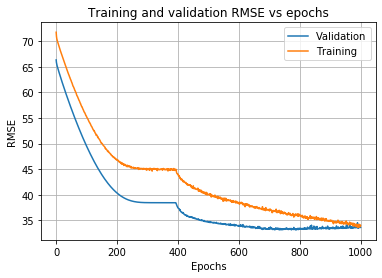

In [ ]:
mean_train = np.mean([42.0392])
mean_test = np.mean([40.7986])

std_train = np.std([32.8142,29.6790,31.8867,33.59,30.9128,29.9082])
std_test = np.std([35.3493,33.4154,35.3549,34.84,31.8757,33.2425])

In [ ]:
mat_data_test = np.zeros((5035,6,121))
mat_data_mean_std_test = np.zeros((5035,6,2))

def find_persentages_2(test_data,Persentage_req_data):
    indexes = []
    for i in range(0,len(test_data[0])):
        count = 0
        count1 = 0
        for p in range(2,len(test_data)):
            listt = test_data[p][i]
            listt = listt.split(',')
            listt2 = []
            count1 += len(listt)
            for j in range(0,len(listt)):
                if listt[j] != "nan":
                    listt2.append(float(listt[j]))
                    count += 1 
            mat_data_mean_std_test[i,p-2,0] = np.max(listt2)
            mat_data_mean_std_test[i,p-2,1] = np.min(listt2)
        persentage_data = count/count1
        if persentage_data<Persentage_req_data:
            indexes.append(i)
    return indexes
for i in range(0,len(test_data[0])):
    for p in range(2,len(test_data)):
        listt = test_data[p][i]
        listt = listt.split(',')
        listt2 = []
        for j in range(0,len(listt)):
            if listt[j] != "nan":
                listt2.append(float(listt[j]))       
        if len(listt2) !=0:
            mean = np.mean(listt2)
            std = np.std(listt2)
            
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = ss.norm.rvs(loc = mean,scale = std)
                    mat_data_test[i,p-2,k] = float(value)
                else:
                    mat_data_test[i,p-2,k] = float(string)
        else:
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = 0
                    mat_data_test[i,p-2,k] = float(0)
                else:
                    mat_data_test[i,p-2,k] = float(string)

In [ ]:
plt.figure(1)
plt.title('Training and validation RMSE vs epochs')
plt.plot(history.history["val_root_mean_squared_error"],label = "Validation")
plt.plot(history.history["root_mean_squared_error"],label = "Training")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.grid()

In [ ]:
indexes2 = find_persentages_2(test_data,0.7)
data_set_input_test = mat_data_test

#data_set_input_test = np.delete(mat_data_train,indexes,axis = 0)
#mat_data_mean_std = np.delete(mat_data_mean_std,indexes,axis = 0)

    
for i in range(len(data_set_input_test)):
    for j in range(len(data_set_input_test[i])):
        array = data_set_input_test[i,j,:]
        maximum = np.max(mat_data_mean_std[:,j,0])
        minimum = np.min(mat_data_mean_std[:,j,1])
        scaled_array= Scaling(array,maximum,minimum)
        data_set_input_test[i,j,:] = scaled_array
        
print(mat_data_mean_std_test[314,4,1])      
data_set_input_test = np.reshape(data_set_input_test,(5035,6,121))

In [ ]:
values = lstm_model.predict(data_set_input_test)
mean_target = np.mean(target)
print(mean_target)
for i in range(len(indexes2)):
    ind = indexes2[i]
    values[ind,0] = mean_target
for j in range(len(values)):
    if values[j,0]>100 or values[j,0]<20:
        values[j,0] = mean_target

In [ ]:
print(values)

In [ ]:
df = pd.DataFrame(values)

filepath = 'predictions.xlsx'

df.to_excel(filepath, index=False)